# Assessment 1: Predict diabetes using Perceptron

## Overview

The first assignment is to implement, describe, and test
a specific algorithm called Perceptron (which can be
interpreted as a dense layer neural network) for predicting
diabetes (using the diabetes dataset provided). 

## Import Packages


In [455]:
# Common imports
import numpy as np
import pandas as pd

# visualizaiton
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning & Deep learning imports
import sklearn
import torch


## Data Loading

In [456]:
# Load data
df = pd.read_csv('diabetes.csv')  # Adjust path and file name as necessary

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

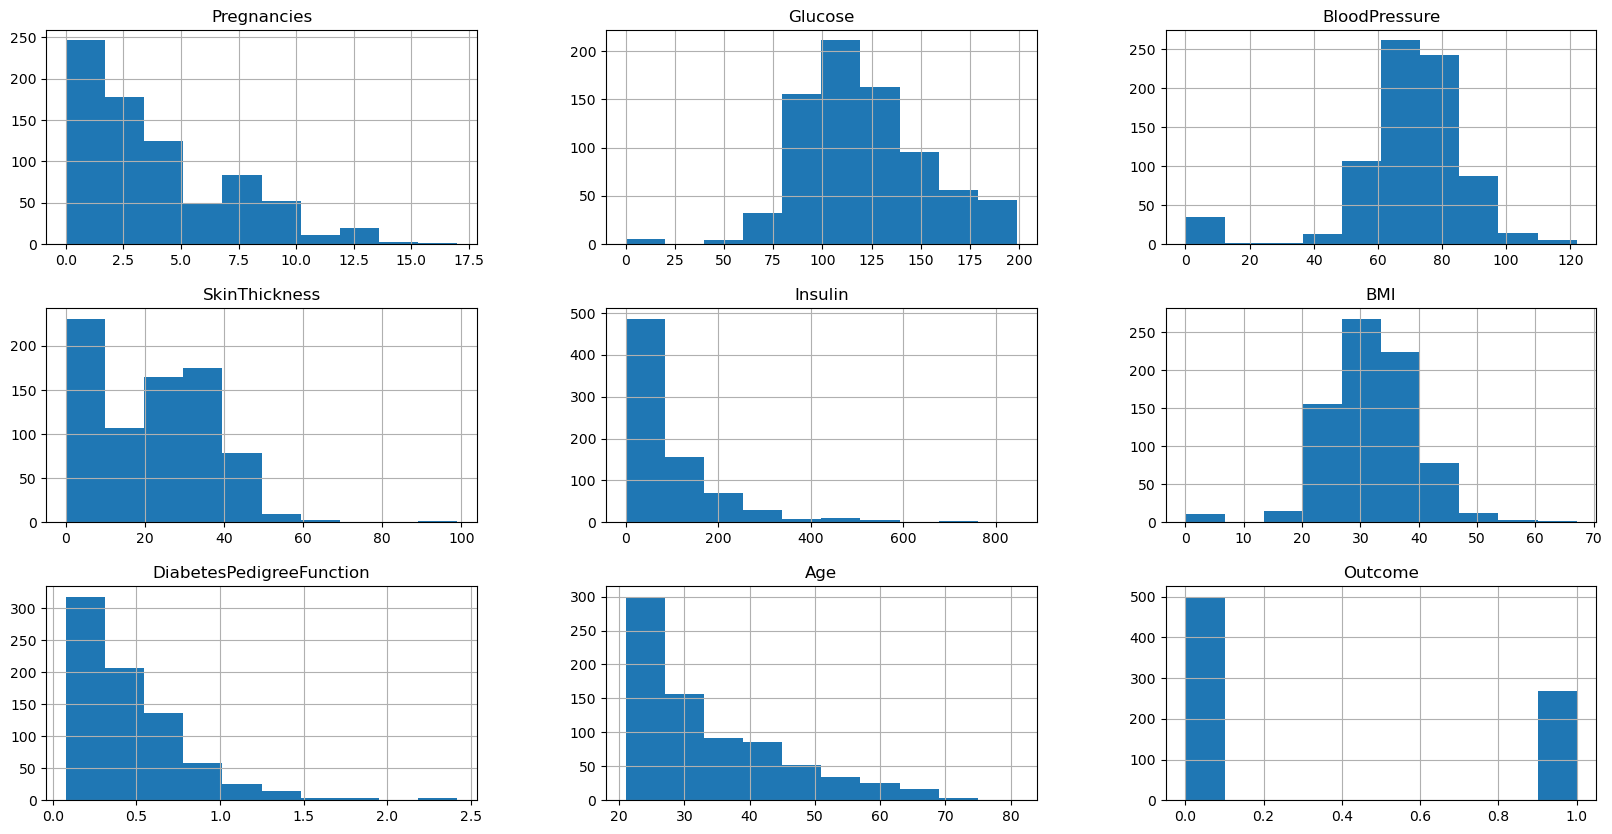

In [457]:
df.hist(figsize=(20,10))

## Check NaN values and the distribution of each feature

In [458]:
features_np = df.drop(columns=['Outcome']).to_numpy()  # Drop the label column and convert to numpy array
df['Outcome'] = df['Outcome'].replace(0, -1)
labels_np = df['Outcome'].to_numpy()      

In [459]:
# Check dataframe
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,-0.302083
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.953903
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,-1.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,-1.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,-1.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


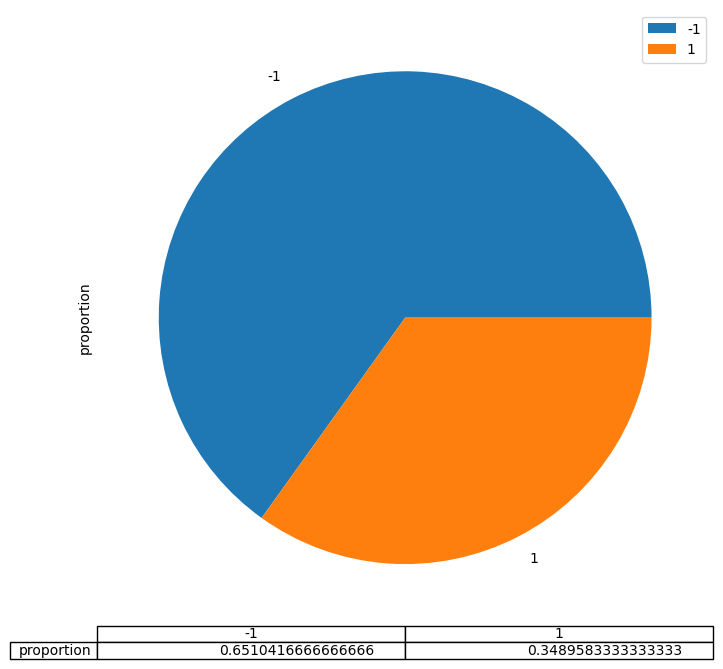

In [584]:
df["Outcome"].value_counts(normalize=True).plot(kind="pie", legend=True, table=True, figsize=(10,8));

<Axes: >

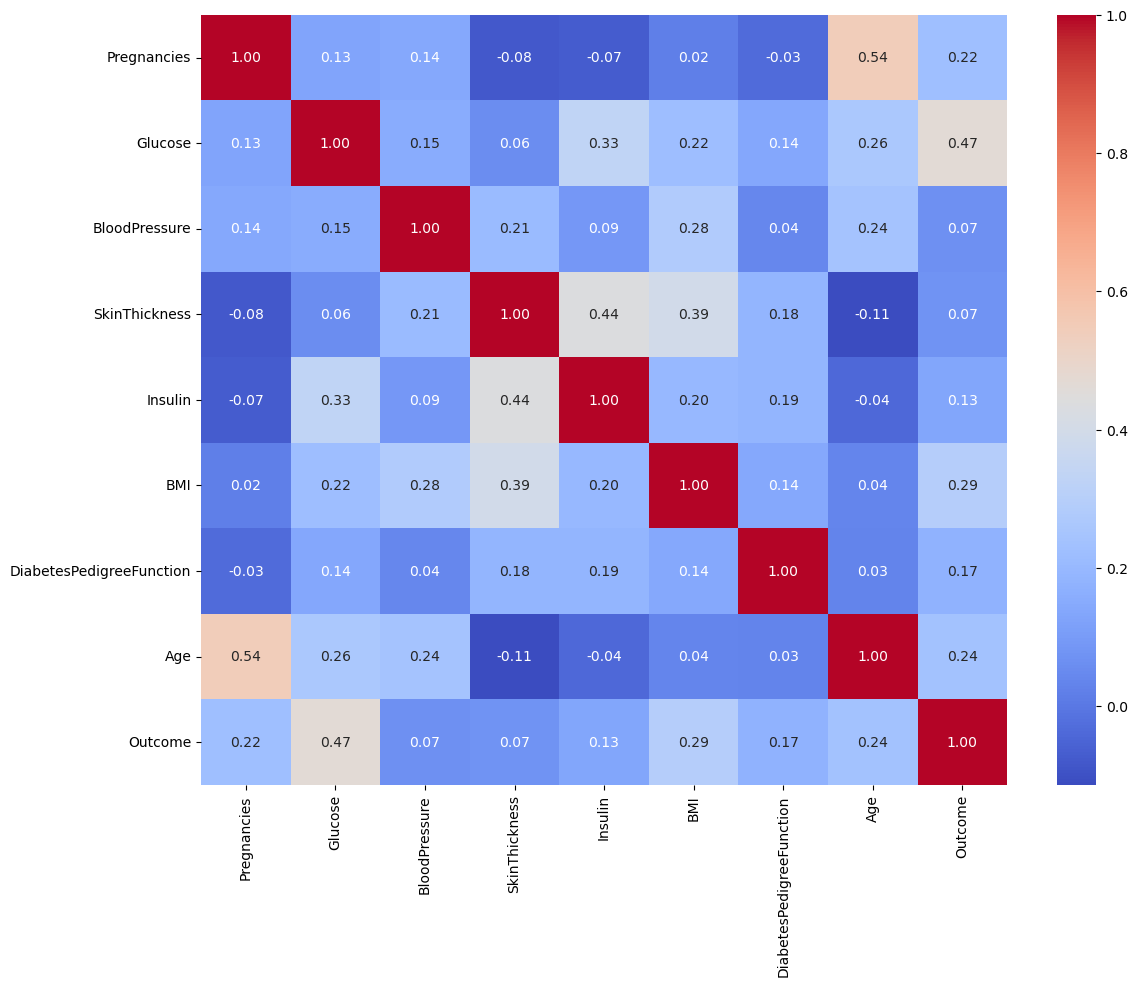

In [460]:
plt.figure(figsize=(13,10))
sns.heatmap(df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

## Perceptron Model

In [461]:
import torch.nn as nn
import torch.optim as optim

class PyTorchPerceptron(nn.Module):
    def __init__(self, input_dim):
        super(PyTorchPerceptron, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 1),               
        )
    
    def forward(self, x):
        return self.fc(x)

In [462]:
def perceptron_loss(outputs, labels):
    # Compute the perceptron loss
    loss = torch.clamp(-labels * outputs, min=0)
    return torch.mean(loss)

In [463]:
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import DataLoader, TensorDataset

class PyTorchPerceptronClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, epochs=20, batch_size=16, learning_rate=0.001):
        self.input_dim = input_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = PyTorchPerceptron(input_dim)
        # self.criterion = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.training_losses = []
        self.validation_losses = []
        
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        # Convert training data to tensors
        X_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
        train_dataset = TensorDataset(X_tensor, y_tensor)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
 
        val_loader = None
        if X_val is not None and y_val is not None:
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
            val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        
        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            total_train_loss = 0
            total_val_loss = 0
            for inputs, targets in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = perceptron_loss(outputs, targets)
                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item()
            avg_train_loss = total_train_loss / len(train_loader)
            self.training_losses.append(avg_train_loss)

            # Validation loop
            if val_loader:
                self.model.eval()
                with torch.no_grad():
                    for inputs, targets in val_loader:
                        outputs = self.model(inputs)
                        loss = perceptron_loss(outputs, targets)
                        total_val_loss += loss.item()
                avg_val_loss = total_val_loss / len(val_loader)
                self.validation_losses.append(avg_val_loss)
                print(f"Epoch {epoch+1}/{self.epochs}: Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {total_val_loss / len(val_loader):.4f}")
    
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor)
        return (outputs.numpy() > 0).astype(int)*2 - 1
    
    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

In [554]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, ClassifierMixin

class PyTorchPerceptronClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, epochs=20, batch_size=16, learning_rate=0.001, patience=8, min_delta=0.001):
        self.input_dim = input_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.patience = patience
        self.min_delta = min_delta
        self.model = PyTorchPerceptron(input_dim)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.best_params = None  # To store the best model parameters
        self.best_val_loss = np.inf
        self.epochs_no_improve = 0
        self.training_losses = []
        self.validation_losses = []

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        X_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
        train_dataset = TensorDataset(X_tensor, y_tensor)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        val_loader = None
        if X_val is not None and y_val is not None:
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
            y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
            val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        self.model.train()
        for epoch in range(self.epochs):
            total_train_loss = 0
            for inputs, targets in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = perceptron_loss(outputs, targets)
                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item()
            # Calculate average training loss for the epoch and append it to training_losses
            avg_train_loss = total_train_loss / len(train_loader)
            self.training_losses.append(avg_train_loss)

            if val_loader:
                self.model.eval()
                total_val_loss = 0
                with torch.no_grad():
                    for inputs, targets in val_loader:
                        outputs = self.model(inputs)
                        loss = perceptron_loss(outputs, targets)
                        total_val_loss += loss.item()

                avg_val_loss = total_val_loss / len(val_loader)
                self.validation_losses.append(avg_val_loss)

                # Early stopping and model saving logic
                if avg_val_loss < self.best_val_loss:
                    if self.best_val_loss - avg_val_loss > self.min_delta:
                        self.best_val_loss = avg_val_loss
                        self.best_params = {k: v.clone() for k, v in self.model.state_dict().items()}  # Deep copy the model params
                        self.epochs_no_improve = 0
                else:
                    self.epochs_no_improve += 1

                if self.epochs_no_improve >= self.patience:
                    print("Early stopping triggered")
                    self.model.load_state_dict(self.best_params)  # Restore the best parameters
                    break

                print(f"Epoch {epoch+1}/{self.epochs}: Train Loss: {total_train_loss / len(train_loader):.4f}, Val Loss: {avg_val_loss:.4f}")

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor)
        return (outputs.numpy() > 0).astype(int)*2 - 1

    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

## Pipeline of imputation and training

In [555]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,-0.302083
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.953903
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,-1.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,-1.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,-1.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [556]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame
# Replace 0 with -1 in 'Outcome' before the split
df['Outcome'] = df['Outcome'].replace(0, -1)

# Splitting the data into train and test sets
X = df.drop(columns=['Outcome'])
y = df['Outcome']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [557]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
638,7,97,76,32,91,40.9,0.871,32
236,7,181,84,21,192,35.9,0.586,51
165,6,104,74,18,156,29.9,0.722,41
729,2,92,52,0,0,30.1,0.141,22
281,10,129,76,28,122,35.9,0.280,39


In [558]:
# Convert columns to float if they are not already to ensure data type compatibility
X_train[['Glucose', 'BloodPressure', 'BMI', 'Insulin']] = X_train[['Glucose', 'BloodPressure', 'BMI', 'Insulin']].astype(float)
X_test[['Glucose', 'BloodPressure', 'BMI', 'Insulin']] = X_test[['Glucose', 'BloodPressure', 'BMI', 'Insulin']].astype(float)

# Now perform the imputation
X_train.loc[X_train['Glucose'] == 0, 'Glucose'] = glucose_mean
X_train.loc[X_train['BloodPressure'] == 0, 'BloodPressure'] = blood_pressure_mean
X_train.loc[X_train['BMI'] == 0, 'BMI'] = bmi_median
X_train.loc[X_train['Insulin'] == 0, 'Insulin'] = insulin_median

X_test.loc[X_test['Glucose'] == 0, 'Glucose'] = glucose_mean
X_test.loc[X_test['BloodPressure'] == 0, 'BloodPressure'] = blood_pressure_mean
X_test.loc[X_test['BMI'] == 0, 'BMI'] = bmi_median
X_test.loc[X_test['Insulin'] == 0, 'Insulin'] = insulin_median

In [559]:
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,3.867391,121.218818,72.149660,20.308696,134.663043,32.497826,0.481172,33.306522
std,3.307386,30.450507,12.494018,15.586442,78.211054,6.797116,0.344756,11.633265
min,0.000000,57.000000,24.000000,0.000000,16.000000,18.200000,0.084000,21.000000
25%,1.000000,99.000000,64.000000,0.000000,120.000000,27.800000,0.244500,24.000000
50%,3.000000,116.000000,72.000000,23.000000,122.000000,32.150000,0.382500,29.000000
75%,6.000000,139.250000,80.000000,32.000000,126.750000,36.325000,0.629500,40.000000
max,13.000000,198.000000,122.000000,60.000000,744.000000,67.100000,2.329000,81.000000


In [560]:
from sklearn.preprocessing import MinMaxScaler
# Initialize the MinMaxScaler with the desired range
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and testing data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# If you need to convert these back to DataFrames:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [561]:
X_train_scaled.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,-0.405017,-0.089095,-0.017354,-0.323043,-0.674003,-0.415222,-0.646172,-0.589783
std,0.508829,0.431922,0.254980,0.519548,0.214866,0.278001,0.307132,0.387776
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.846154,-0.404255,-0.183673,-1.000000,-0.714286,-0.607362,-0.857016,-0.900000
50%,-0.538462,-0.163121,-0.020408,-0.233333,-0.708791,-0.429448,-0.734076,-0.733333
75%,-0.076923,0.166667,0.142857,0.066667,-0.695742,-0.258691,-0.514031,-0.366667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>, <Axes: >]], dtype=object)

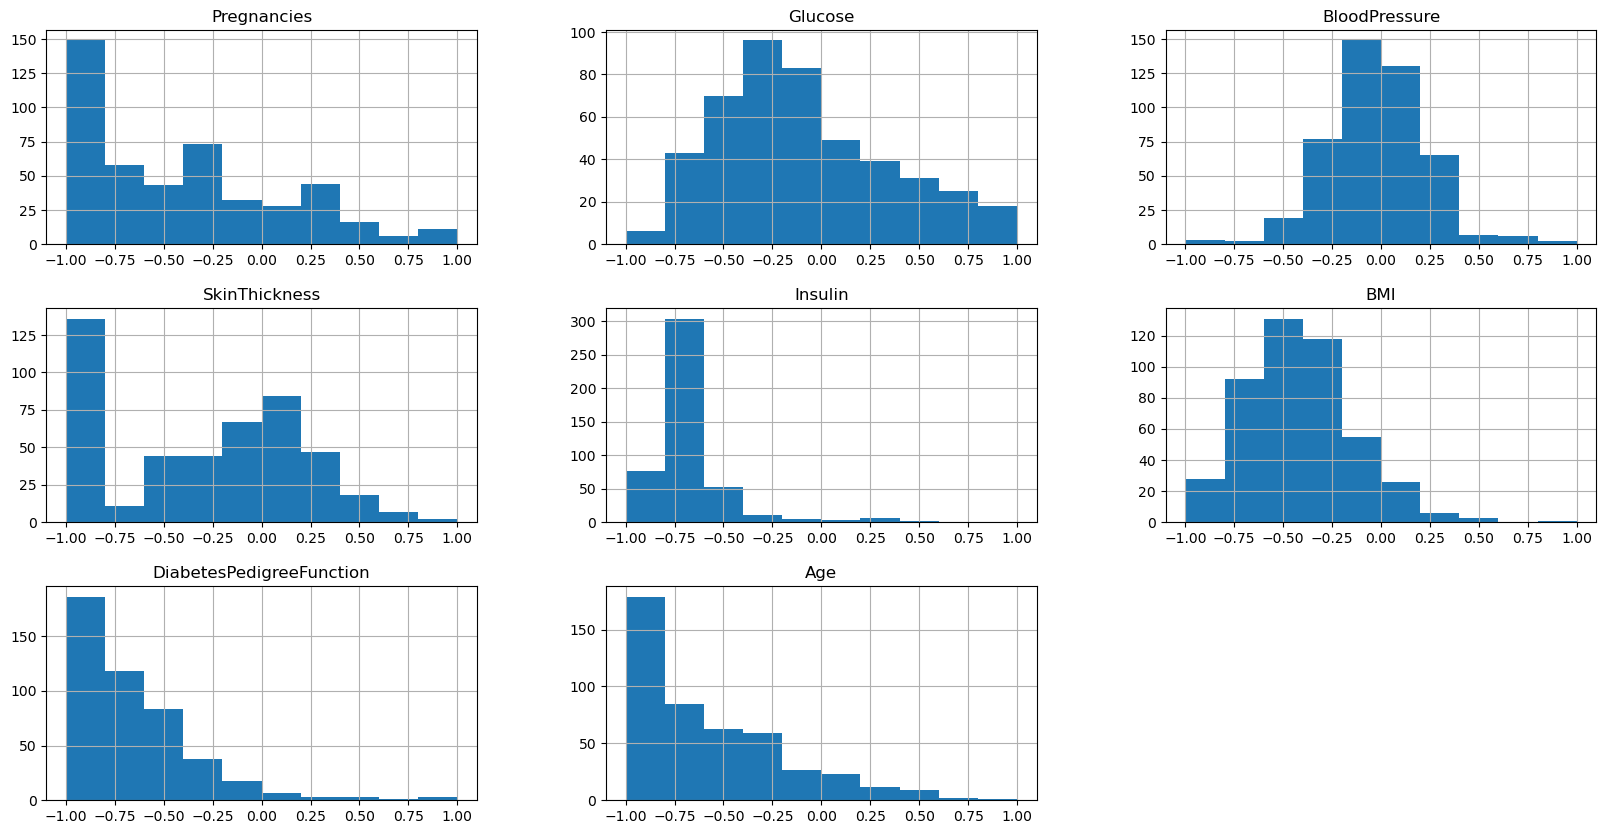

In [585]:
X_train_scaled.hist(figsize=(20,10))

<Axes: >

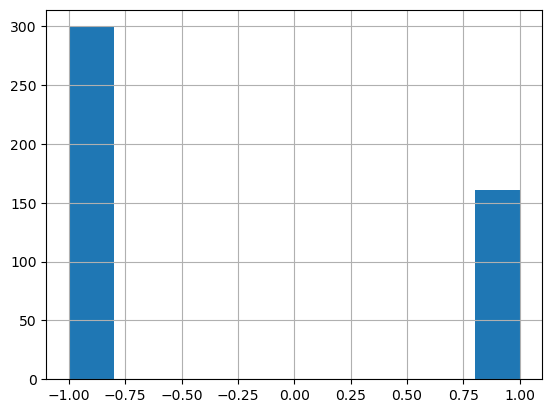

In [563]:
y_train.hist()

In [564]:
# Convert DataFrames to numpy arrays for modeling
X_train = X_train_scaled.to_numpy()
X_val = X_val_scaled.to_numpy()
X_test = X_test_scaled.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [565]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np

# Load and split your data
# X and y should be loaded as numpy arrays from your dataset
X_train, X_temp, y_train, y_temp = train_test_split(features_np, labels_np, test_size=0.4, random_state=42, stratify=labels_np)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [566]:
X_train.shape

(460, 8)

In [567]:
# train the model
classifier = PyTorchPerceptronClassifier(input_dim=X_train.shape[1],epochs=20, batch_size=16, learning_rate=0.01)
classifier.fit(X_train, y_train, X_val=X_val, y_val=y_val)

Epoch 1/20: Train Loss: 11.1710, Val Loss: 6.4454
Epoch 2/20: Train Loss: 3.0115, Val Loss: 2.4235
Epoch 3/20: Train Loss: 1.5221, Val Loss: 1.4689
Epoch 4/20: Train Loss: 1.0910, Val Loss: 0.8798
Epoch 5/20: Train Loss: 0.7674, Val Loss: 0.8102
Epoch 6/20: Train Loss: 0.5589, Val Loss: 0.5614
Epoch 7/20: Train Loss: 0.4228, Val Loss: 0.3105
Epoch 8/20: Train Loss: 0.3742, Val Loss: 0.4798
Epoch 9/20: Train Loss: 0.3360, Val Loss: 0.2969
Epoch 10/20: Train Loss: 0.2366, Val Loss: 0.2804
Epoch 11/20: Train Loss: 0.2295, Val Loss: 0.1826
Epoch 12/20: Train Loss: 0.1975, Val Loss: 0.1752
Epoch 13/20: Train Loss: 0.1154, Val Loss: 0.5411
Epoch 14/20: Train Loss: 0.3642, Val Loss: 0.5394
Epoch 15/20: Train Loss: 0.3464, Val Loss: 0.2085
Epoch 16/20: Train Loss: 0.1366, Val Loss: 0.3889
Epoch 17/20: Train Loss: 0.1766, Val Loss: 0.3252
Epoch 18/20: Train Loss: 0.1733, Val Loss: 0.2531
Epoch 19/20: Train Loss: 0.2494, Val Loss: 0.3209
Early stopping triggered


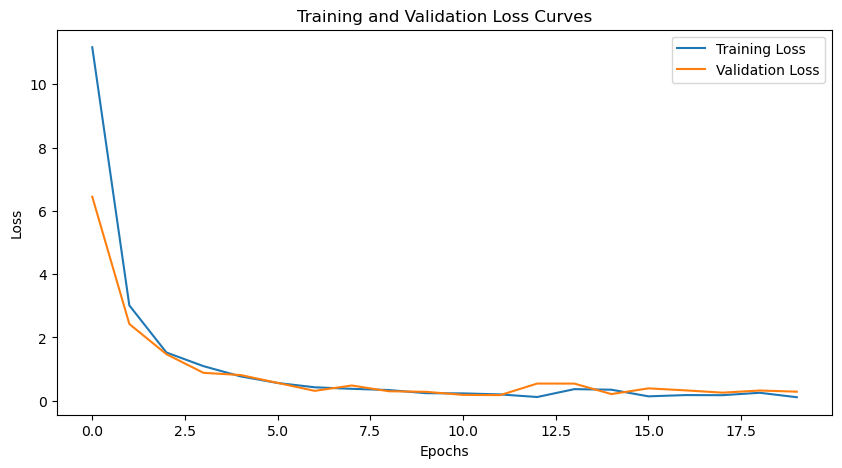

In [568]:
# Plot training and validation losses, assuming these are stored in the classifier after fitting
plt.figure(figsize=(10, 5))
plt.plot(classifier.training_losses, label='Training Loss')
plt.plot(classifier.validation_losses, label='Validation Loss')  
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [569]:
# Predict using the classifier
y_val_pred = classifier.predict(X_val)

In [570]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_val, y_val_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.4740
Confusion Matrix:
 [[25 75]
 [ 6 48]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.81      0.25      0.38       100
           1       0.39      0.89      0.54        54

    accuracy                           0.47       154
   macro avg       0.60      0.57      0.46       154
weighted avg       0.66      0.47      0.44       154



In [571]:
from sklearn.metrics import f1_score, classification_report

# Setup for manual hyperparameter tuning
param_grid = {
    'batch_size': [8, 16],
    'learning_rate': [0.1, 0.05, 0.01, 0.005]
}
best_f1_score = -np.inf
best_params = {}

# Iterate over all combinations of hyperparameters
for batch_size in param_grid['batch_size']:
    for learning_rate in param_grid['learning_rate']:
        # Initialize the classifier with current set of parameters
        classifier = PyTorchPerceptronClassifier(input_dim=X_train.shape[1], epochs=100, 
                                                 batch_size=batch_size, learning_rate=learning_rate)
        # Train the model
        classifier.fit(X_train, y_train, X_val=X_val, y_val=y_val)

        # Validate the model
        y_pred = classifier.predict(X_val)

        # Calculate F1 score and classification report
        current_f1_score = f1_score(y_val, y_pred, average='binary')
        current_classification_report = classification_report(y_val, y_pred)

        # Print the classification report
        print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}")
        print(current_classification_report)

        # Store the best parameters based on F1 score
        if current_f1_score > best_f1_score:
            best_f1_score = current_f1_score
            best_params = {
                'batch_size': batch_size,
                'learning_rate': learning_rate,
                'f1_score': best_f1_score
            }
            # Optionally save model
            best_model_weights = classifier.model.state_dict()

print("Best F1 score:", best_f1_score)
print("Best parameters:", best_params)

Epoch 1/100: Train Loss: 5.4833, Val Loss: 3.6704
Epoch 2/100: Train Loss: 2.4354, Val Loss: 1.3950
Epoch 3/100: Train Loss: 1.9857, Val Loss: 0.4572
Epoch 4/100: Train Loss: 2.3171, Val Loss: 2.5460
Epoch 5/100: Train Loss: 6.4074, Val Loss: 3.4910
Epoch 6/100: Train Loss: 2.1881, Val Loss: 2.2205
Epoch 7/100: Train Loss: 3.5607, Val Loss: 14.2323
Epoch 8/100: Train Loss: 5.1845, Val Loss: 1.5439
Epoch 9/100: Train Loss: 4.3081, Val Loss: 2.6859
Epoch 10/100: Train Loss: 2.9776, Val Loss: 3.6455
Early stopping triggered
Batch Size: 8, Learning Rate: 0.1
              precision    recall  f1-score   support

          -1       0.73      0.95      0.82       100
           1       0.78      0.33      0.47        54

    accuracy                           0.73       154
   macro avg       0.75      0.64      0.65       154
weighted avg       0.75      0.73      0.70       154

Epoch 1/100: Train Loss: 3.1586, Val Loss: 1.4817
Epoch 2/100: Train Loss: 1.6954, Val Loss: 1.8166
Epoch 3/100:

Epoch 1/100: Train Loss: 5.5163, Val Loss: 5.2181
Epoch 2/100: Train Loss: 5.0200, Val Loss: 5.2394
Epoch 3/100: Train Loss: 3.5450, Val Loss: 1.6737
Epoch 4/100: Train Loss: 2.9868, Val Loss: 3.5431
Epoch 5/100: Train Loss: 2.0183, Val Loss: 5.5353
Epoch 6/100: Train Loss: 3.4517, Val Loss: 2.4672
Epoch 7/100: Train Loss: 2.2866, Val Loss: 2.2612
Epoch 8/100: Train Loss: 2.8083, Val Loss: 1.5407
Epoch 9/100: Train Loss: 1.6667, Val Loss: 2.6816
Epoch 10/100: Train Loss: 2.6583, Val Loss: 4.2414
Epoch 11/100: Train Loss: 3.6940, Val Loss: 3.2894
Epoch 12/100: Train Loss: 3.1869, Val Loss: 3.4141
Epoch 13/100: Train Loss: 2.1921, Val Loss: 1.0631
Epoch 14/100: Train Loss: 3.8040, Val Loss: 0.9664
Epoch 15/100: Train Loss: 1.6216, Val Loss: 1.6125
Epoch 16/100: Train Loss: 2.5593, Val Loss: 1.9738
Epoch 17/100: Train Loss: 2.9727, Val Loss: 1.4374
Epoch 18/100: Train Loss: 1.5822, Val Loss: 2.8141
Epoch 19/100: Train Loss: 3.1175, Val Loss: 3.7778
Epoch 20/100: Train Loss: 2.3373, Val Lo

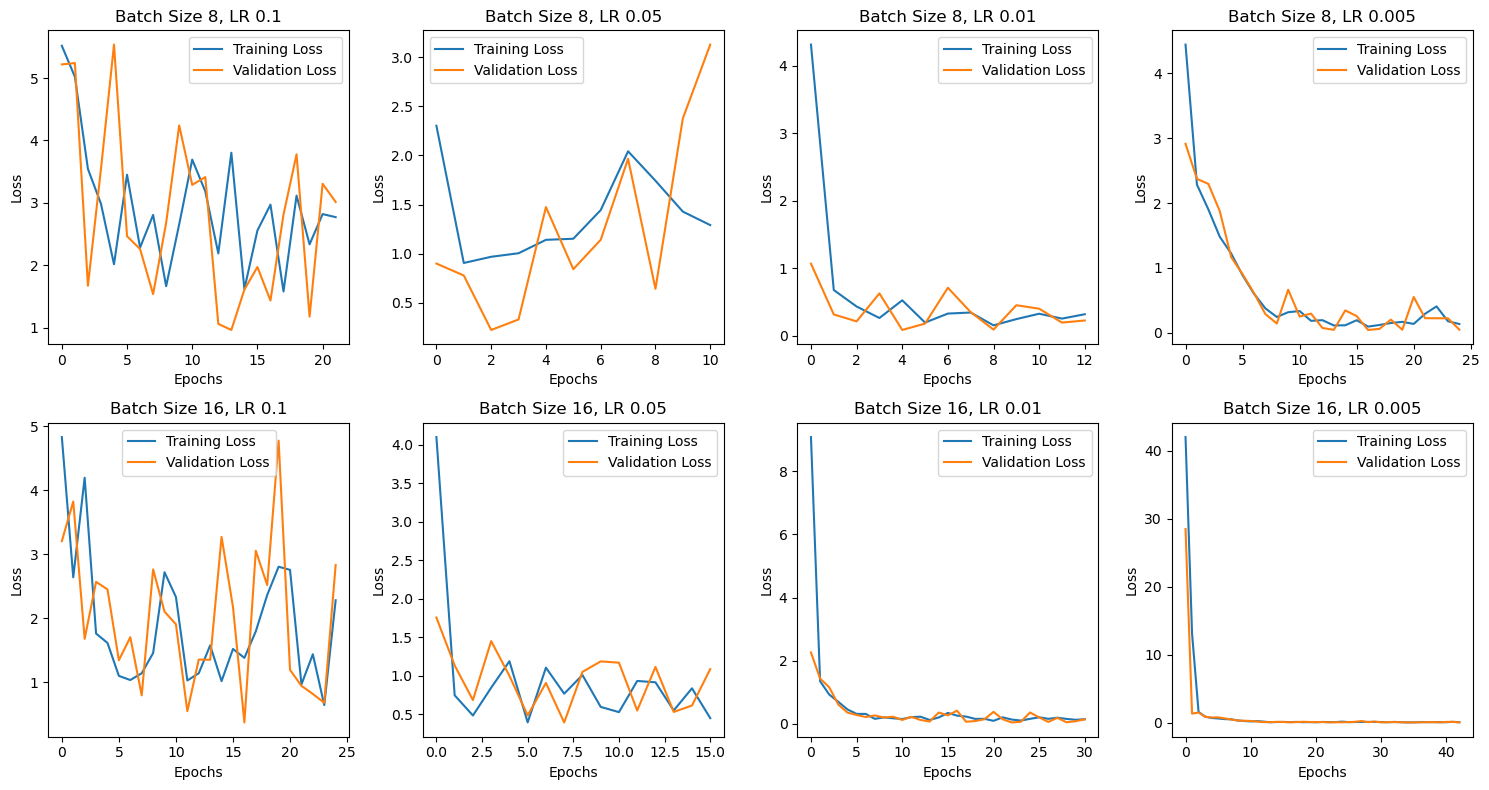

Best F1 score: 0.613861386138614
Best parameters: {'batch_size': 16, 'learning_rate': 0.005, 'f1_score': 0.613861386138614}


In [583]:
import numpy as np
import torch
from sklearn.metrics import f1_score, classification_report
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Setup for manual hyperparameter tuning
param_grid = {
    'batch_size': [8, 16],
    'learning_rate': [0.1, 0.05, 0.01, 0.005]
}
best_f1_score = -np.inf
best_params = {}
all_losses = {}

# Iterate over all combinations of hyperparameters
for batch_size in param_grid['batch_size']:
    for learning_rate in param_grid['learning_rate']:
        # Initialize the classifier with current set of parameters
        classifier = PyTorchPerceptronClassifier(input_dim=X_train.shape[1], epochs=100, 
                                                 batch_size=batch_size, learning_rate=learning_rate)
        # Train the model
        classifier.fit(X_train, y_train, X_val=X_val, y_val=y_val)

        # Validate the model
        y_pred = classifier.predict(X_val)

        # Calculate F1 score and classification report
        current_f1_score = f1_score(y_val, y_pred, average='binary')
        current_classification_report = classification_report(y_val, y_pred)

        # Print the classification report
        print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}")
        print(current_classification_report)

        # Store the training and validation losses
        all_losses[(batch_size, learning_rate)] = (classifier.training_losses, classifier.validation_losses)

        # Store the best parameters based on F1 score
        if current_f1_score > best_f1_score:
            best_f1_score = current_f1_score
            best_params = {
                'batch_size': batch_size,
                'learning_rate': learning_rate,
                'f1_score': best_f1_score
            }
            # Optionally save model
            best_model_weights = classifier.model.state_dict()

# Plotting the learning curves
fig, axes = plt.subplots(nrows=len(param_grid['batch_size']), ncols=len(param_grid['learning_rate']), figsize=(15, 8))
for idx, ((batch_size, learning_rate), (train_losses, val_losses)) in enumerate(all_losses.items()):
    row = idx // len(param_grid['learning_rate'])
    col = idx % len(param_grid['learning_rate'])
    ax = axes[row, col]
    ax.plot(train_losses, label='Training Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_title(f'Batch Size {batch_size}, LR {learning_rate}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
plt.show()

print("Best F1 score:", best_f1_score)
print("Best parameters:", best_params)

In [578]:
# train the model
classifier = PyTorchPerceptronClassifier(input_dim=X_train.shape[1],epochs=100, batch_size=16, learning_rate=0.005)
classifier.fit(X_train, y_train, X_val=X_val, y_val=y_val)

Epoch 1/100: Train Loss: 21.3406, Val Loss: 11.6123
Epoch 2/100: Train Loss: 5.5316, Val Loss: 3.9238
Epoch 3/100: Train Loss: 3.3690, Val Loss: 1.8990
Epoch 4/100: Train Loss: 2.0509, Val Loss: 1.1557
Epoch 5/100: Train Loss: 1.2428, Val Loss: 0.7118
Epoch 6/100: Train Loss: 0.7128, Val Loss: 0.5378
Epoch 7/100: Train Loss: 0.5436, Val Loss: 0.4895
Epoch 8/100: Train Loss: 0.4741, Val Loss: 0.4361
Epoch 9/100: Train Loss: 0.3990, Val Loss: 0.4253
Epoch 10/100: Train Loss: 0.3463, Val Loss: 0.3748
Epoch 11/100: Train Loss: 0.2986, Val Loss: 0.3745
Epoch 12/100: Train Loss: 0.2503, Val Loss: 0.2752
Epoch 13/100: Train Loss: 0.2886, Val Loss: 0.2058
Epoch 14/100: Train Loss: 0.2262, Val Loss: 0.2428
Epoch 15/100: Train Loss: 0.2357, Val Loss: 0.3046
Epoch 16/100: Train Loss: 0.1826, Val Loss: 0.2067
Epoch 17/100: Train Loss: 0.1137, Val Loss: 0.0901
Epoch 18/100: Train Loss: 0.1057, Val Loss: 0.1127
Epoch 19/100: Train Loss: 0.1259, Val Loss: 0.0666
Epoch 20/100: Train Loss: 0.1001, Val 

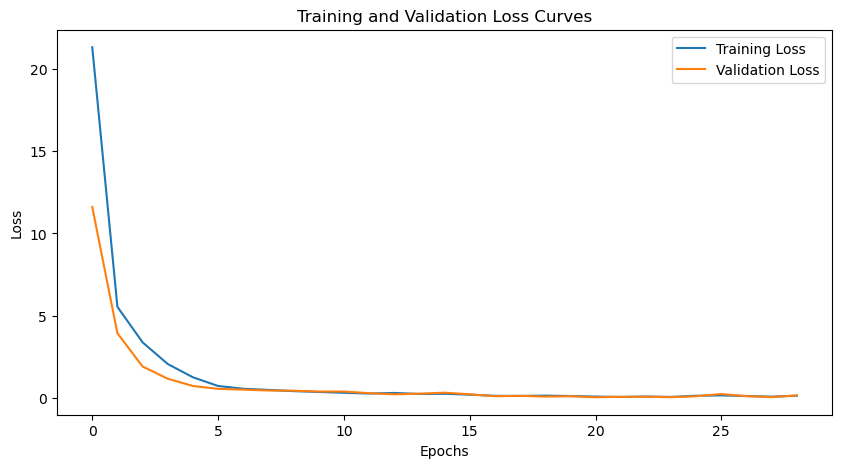

In [579]:
# Plot training and validation losses, assuming these are stored in the classifier after fitting
plt.figure(figsize=(10, 5))
plt.plot(classifier.training_losses, label='Training Loss')
plt.plot(classifier.validation_losses, label='Validation Loss')  # Make sure validation losses are recorded
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [580]:
# Predict using the classifier
y_pred = classifier.predict(X_test)

In [581]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.6169
Confusion Matrix:
 [[58 43]
 [16 37]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.78      0.57      0.66       101
           1       0.46      0.70      0.56        53

    accuracy                           0.62       154
   macro avg       0.62      0.64      0.61       154
weighted avg       0.67      0.62      0.63       154

